<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/4_1_pre_training_weight_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Pre-training ⭐

---

🚆 Pre-train the model built in [notebook link](https://github.com/chen-star/llm_model_trainings/blob/main/3_4_transformer_impl_full_transformer_decoder.ipynb):

**Weight initialization**

* Why do weights need to be initialized?
~~~text
-> Small weights (those ~= 0) increase risk of vanishing gradients.

-> Large weights increase risk of exploding gradients.
~~~

---

# ✈ Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from typing import override

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# Use the same parameters a GPT2-124M
batch_size = 8

num_transformer_blocks = 12

embedding_dimension = 768
num_heads = 12 # embedding_dimension must be divisible by num_heads

context_window_size = 1024
vocabulary_size = 50257

# 📂 Prepare Train / Test Data

In [4]:
# import GPT2 tokenizer
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [5]:
# download << Romeo and Juliet >>
text = requests.get('https://www.gutenberg.org/cache/epub/1513/pg1513.txt').text
token_ids = torch.tensor( tokenizer.encode(text),dtype=torch.long )
print(f'Token size: {len(token_ids)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (56185 > 1024). Running this sequence through the model will result in indexing errors


Token size: 56185


In [6]:
# split train / test data
train_ratio = 0.85

train_size = int(train_ratio * len(token_ids))
train_data = token_ids[:train_size]
test_data = token_ids[train_size:]

In [7]:
# define a func to get data batches
def get_batch(data, batch_size, context_window_size):
  # generate random start idx
  random_indices = torch.randint(0, len(data) - context_window_size, (batch_size,))

  # X and targets
  X = data[random_indices[:, None] + torch.arange(context_window_size)]
  Y = data[random_indices[:, None] + torch.arange(1, context_window_size + 1)]

  return X, Y

In [8]:
def get_train_batch():
  return get_batch(train_data, batch_size, context_window_size)

def get_test_batch():
  return get_batch(test_data, batch_size, context_window_size)

# [0] 🏚 Model

The model built in [notebook link](https://github.com/chen-star/llm_model_trainings/blob/main/3_4_transformer_impl_full_transformer_decoder.ipynb).

### (0.1) 👓 Multi-head Attention

In [9]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embedding_dimension, num_heads):
    super().__init__()

    # define W_Q, W_K, W_V
    self.q_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)
    self.k_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)
    self.v_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)

    # define W0
    self.w0_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)

    # ***** multi-head *****
    self.num_heads = num_heads
    self.head_dimension = embedding_dimension // num_heads
    # *****************************


  @override
  def forward(self, X):
    batch_size, context_window_size, embedding_dimension = X.shape

    # Q = XW_Q
    # K = XW_K
    # V = XW_V
    Q = self.q_layer(X)
    K = self.k_layer(X)
    V = self.v_layer(X)

    # ***** Split Q,K,V *****
    Q = Q.view(batch_size, context_window_size, self.num_heads, self.head_dimension)
    K = K.view(batch_size, context_window_size, self.num_heads, self.head_dimension)
    V = V.view(batch_size, context_window_size, self.num_heads, self.head_dimension)

    # For attention score calculation, pytorch expects the shape to be
    # [batch_size, num_heads, context_window_size, head_dimension]
    Q = Q.transpose(1,2)
    K = K.transpose(1,2)
    V = V.transpose(1,2)
    # *****************************

    attention_score = F.scaled_dot_product_attention(Q, K, V, is_causal=True)

    # Transpose back
    attention_score = attention_score.transpose(1,2)

    # ***** Merge heads *****
    attention_score = attention_score.reshape(batch_size, context_window_size, embedding_dimension)
    # *****************************

    return self.w0_layer(attention_score)

### (0.2) 🏃 Single MLP

In [10]:
class MLP(nn.Module):
  def __init__(self, embedding_dimension, expansion: int=4):
    super().__init__()

    # define W1, Gelu, W2
    self.w1_layer = nn.Linear(embedding_dimension, expansion * embedding_dimension) # 4x expansion
    self.gelu = nn.GELU()
    self.w2_layer = nn.Linear(expansion * embedding_dimension, embedding_dimension) # 4x contraction


  @override
  def forward(self, X):
    W1 = self.w1_layer(X)
    GELU = self.gelu(W1)
    W2 = self.w2_layer(GELU)

    return W2

### (0.3) 🔲 Transformer Block

In [11]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dimension):
    super().__init__()

    # Attention
    self.layerNorm_attention = nn.LayerNorm(embedding_dimension)
    self.attention_heads = MultiHeadAttention(embedding_dimension, num_heads)

    # MLP / FeedForward
    self.layerNorm_mlp = nn.LayerNorm(embedding_dimension)
    self.mlp = MLP(embedding_dimension)


  @override
  def forward(self, X):
    # --- Attention ---
    # X -> layerNorm -> attention_head
    #                                     +   = output
    #                                X
    X = X + self.attention_heads(self.layerNorm_attention(X))

    # --- MLP ---
    # X -> layerNorm -> mlp
    #                         +   = output
    #                     X
    X = X + self.mlp(self.layerNorm_mlp(X))

    return X


# [1] ✏ Weight Init

### (1.1) 🔖 Define Model

In [12]:
class LanguageModel(nn.Module):
  def __init__(self, device):
    super().__init__()

    self.device = device

    # ----- Token Embedding + Position Encoding -----
    self.wte = nn.Embedding(vocabulary_size, embedding_dimension) # token embedding
    self.wpe = nn.Embedding(context_window_size, embedding_dimension) # position encoding

    # ----- Transformer Blocks -----
    self.transformer_blocks = nn.Sequential(*[
          TransformerBlock(embedding_dimension) for _ in range(num_transformer_blocks)
        ])

    # ----- Final layernorm -----
    self.final_layernorm = nn.LayerNorm(embedding_dimension)

    # ----- Unembedding -----
    self.unembedding = nn.Linear(embedding_dimension, vocabulary_size, bias=False)
    # tied unembedding weights
    self.unembedding.weight = nn.Parameter(self.wte.weight)


    # ------ Weight Init -----
    self.apply(self._init_weights)


  def _init_weights(self, module):
    # If current layer is linear, init with normal distribution
    if isinstance(module, nn.Linear):
      nn.init.normal_(module.weight, mean=0, std=0.02)
      # If current layer has biases, init biases to zero
      if module.bias is not None:
        nn.init.zeros_(module.bias)

    if isinstance(module, nn.Embedding):
      nn.init.xavier_normal_(module.weight)


  @override
  def forward(self, token_ids):
    # ----- Token Embedding + Position Encoding -----
    # [batch_size, context_window_size, embedding_dimension]
    token_embedding = self.wte(token_ids)
    # [context_window_size, embedding_dimension]
    position_emcoding = self.wpe(torch.arange(token_ids.shape[-1], device=self.device))
    # [batch_size, context_window_size, embedding_dimension]
    X = token_embedding + position_emcoding

    # ----- Transformer Blocks -----
    X = self.transformer_blocks(X)

    # ----- Final layernorm -----
    X = self.final_layernorm(X)

    # ----- Unembedding -----
    # [batch_size, context_window_size, vocab_size]
    logits = self.unembedding(X)

    return logits
  def generate(self, token_ids, temperature=1.1, num_new_tokens=10):
    for _ in range(0, num_new_tokens):
      # forward
      # [batch_size, context_window_size, vocab_size]
      logits = self(token_ids[:, -context_window_size:])
      # [batch_size, vocab_size]
      logits = logits[:, -1, :] # last token's logits

      # softmax
      # [batch_size, vocab_size]
      probabilities = F.softmax(logits / temperature, dim=-1)

      # sample
      # [batch_size, 1]
      next_token_id = torch.multinomial(probabilities, num_samples=1)

      # append
      token_ids = torch.cat((token_ids, next_token_id), dim=1)

      return token_ids

### (1.2) 🖲 Train Model

In [13]:
# create a model instance
model = LanguageModel(device).to(device)

In [14]:
# create the loss and optimizer functions
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)

In [15]:
# init losses
train_loss = []
test_loss = []

In [16]:
sample_size = 666 + 1

for i in range(sample_size):
  X, targets = get_train_batch()
  X = X.to(device)
  targets = targets.to(device)

  # clear previous gradients
  model.zero_grad(set_to_none=True)

  # forward
  log_probs = model(X)

  # calc losses
  loss = loss_function(
      log_probs.view(-1, log_probs.shape[-1]),
      targets.view(-1)
  )

  # back propagate
  loss.backward()
  optimizer.step()

  # save loss
  train_loss.append(loss.item())

  # during training, test on test data
  if i%111 == 0: # test 6 times
    with torch.no_grad():
      X, targets = get_test_batch()
      X = X.to(device)
      targets = targets.to(device)

      # forward
      output = model(X)

      # calc losses
      curr_test_loss = loss_function(
          output.view(-1, output.shape[-1]),
          targets.view(-1)
      )

      # save loss
      test_loss.append(curr_test_loss.item())
      print(f"test the [{i//111}th] data, current test loss is: {test_loss[-1]}")

print(f"mean train loss: {np.mean(train_loss)}")
print(f"mean test loss: {np.mean(test_loss)}")

test the [0th] data, current test loss is: -1.3252832889556885
test the [1th] data, current test loss is: -78.15104675292969
test the [2th] data, current test loss is: -226.57412719726562
test the [3th] data, current test loss is: -435.824462890625
test the [4th] data, current test loss is: -715.3743896484375
test the [5th] data, current test loss is: -1019.90283203125
test the [6th] data, current test loss is: -1383.8614501953125
mean train loss: -643.4822124206479
mean test loss: -551.5733702863965


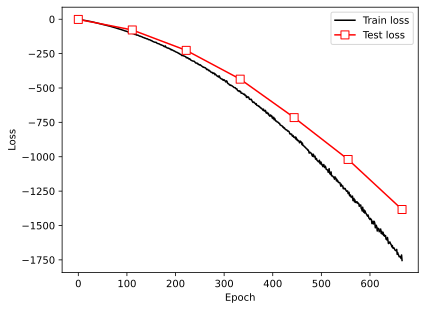

In [18]:
# plot the losses
plt.plot(train_loss,'k',label='Train loss')
plt.plot(range(0, sample_size, 111),test_loss,'rs-',markerfacecolor='w',markersize=8,label='Test loss')

plt.legend()
plt.gca().set(xlabel='Epoch',ylabel='Loss')
plt.show()